# Prerrequisitos

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
from sklearn.model_selection import KFold
#from keras.optimizers import Adam
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from keras.layers import Dense, Flatten, Dropout,Activation,BatchNormalization, Convolution2D, MaxPooling2D,Conv1D,MaxPooling1D
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# CNN_V2

In [ ]:
def cnn_v2():
  model = Sequential()
  model.add(Conv1D(filters=16,kernel_size=3,padding='same',activation='relu',input_shape=(300,1)))
  model.add(BatchNormalization())

  model.add(Conv1D(filters=64,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling1D(pool_size=2,strides=2))

  model.add(Conv1D(filters=128,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling1D(pool_size=2,strides=2))


  model.add(Conv1D(filters=128,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling1D(pool_size=2,strides=2))
  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dense(150, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(20,activation='relu'))
  model.add(Dense(2, activation='linear'))#input: 512 #output:100 
  model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

  model.summary
  return model

In [ ]:
def normalize(x):
  x_norm = (x - x.mean(axis=1)[:,None]) / x.std(axis = 1)[:,None]
  return x_norm


# 50 patients

Cargamos lista de 50 pacientes elegidos (patient ID y ICU stay ID)

In [ ]:
import pandas as pd
patients = pd.read_csv('/content/drive/My Drive/Proyecto Final/Lista_50_CAPITULO1.csv',sep=',')
patients = patients.drop(columns=['Unnamed: 0'])
patients = patients.rename(columns = {'0':'PatientID', '1':'IcuStay'}, inplace = False)
patients.head()

,PatientID,IcuStay
0,p004331,265287
1,p002639,228514
2,p011431,262203
3,p012878,297819
4,p014328,224216


primero tenemos que definir la cantidad de pulsos que querermos N = 120, 200, 400 ...

## Tratamiento de ppg para obtener la x

In [ ]:
ppg_400=pd.read_csv('/content/drive/My Drive/Proyecto Final/50patients/ppg_cnn_400_50patients.csv', sep=',')
ppg_400 = ppg_400.drop(columns = ['Unnamed: 0'])
print(f'the shape is {ppg_400.shape}')
ppg_400.head()

the shape is (19747, 377)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376
0,p014328,224216,0.332356,0.352884,0.375367,0.398827,0.423265,0.443793,0.462366,0.521994,0.602151,0.651026,0.684262,0.705767,0.719453,0.727273,0.731183,0.729228,0.724340,0.715543,0.703812,0.688172,0.670577,0.650049,0.627566,0.606061,0.584555,0.565005,0.546432,0.529814,0.515152,0.502444,0.491691,0.483871,0.475073,0.468231,0.460411,0.453568,0.445748,0.437928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,p014328,224216,0.340176,0.369501,0.400782,0.431085,0.458456,0.482893,0.501466,0.514174,0.523949,0.531769,0.535679,0.537634,0.538612,0.536657,0.533724,0.528837,0.521994,0.514174,0.505376,0.494624,0.483871,0.471163,0.457478,0.442815,0.429130,0.416422,0.403715,0.392962,0.383187,0.373412,0.365591,0.357771,0.351906,0.345064,0.338221,0.332356,0.328446,0.326491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,p014328,224216,0.289345,0.315738,0.344086,0.374389,0.404692,0.433040,0.459433,0.482893,0.502444,0.517107,0.526882,0.536657,0.543500,0.548387,0.551320,0.552297,0.550342,0.546432,0.539589,0.530792,0.520039,0.507331,0.494624,0.480938,0.465298,0.448680,0.431085,0.413490,0.396872,0.381232,0.368524,0.358749,0.350929,0.345064,0.340176,0.337243,0.334311,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,p014328,224216,0.242424,0.245357,0.250244,0.258065,0.270772,0.285435,0.303030,0.325513,0.352884,0.382209,0.413490,0.442815,0.470186,0.493646,0.517107,0.539589,0.553275,0.562072,0.566960,0.567937,0.567937,0.565005,0.561095,0.555230,0.547410,0.537634,0.526882,0.514174,0.500489,0.484848,0.471163,0.456500,0.441838,0.427175,0.413490,0.400782,0.390029,0.381232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,p014328,224216,0.304985,0.326491,0.350929,0.379277,0.404692,0.428152,0.454545,0.479961,0.504399,0.524927,0.541544,0.555230,0.565005,0.571848,0.575758,0.577713,0.576735,0.573803,0.568915,0.563050,0.555230,0.546432,0.535679,0.523949,0.510264,0.495601,0.478983,0.462366,0.446725,0.433040,0.420332,0.408602,0.396872,0.387097,0.379277,0.372434,0.367546,0.364614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Tratamiento de ABP para obtener la y

In [ ]:
import numpy as np
import pandas as pd
abp_400 = pd.read_csv('/content/drive/My Drive/Proyecto Final/50patients/abp_cnn_400_50patients.csv',sep=',')
abp_400 = abp_400.drop(columns = ['Unnamed: 0'])
abp_400 = np.transpose(abp_400)
abp_400.head()

,0,1,2,3
0,p014328,224216,91.91661793782131,65.90617073413998
0.1,p014328,224216,94.06785793211077,68.74189618115787
0.2,p014328,224216,93.57893975159044,68.74189618115787
0.3,p014328,224216,92.69888702665386,67.5684925479091
0.4,p014328,224216,94.16564156821484,67.76405982011721


In [ ]:
N = 120
y_120 = pd.DataFrame()
for i, data in patients.iterrows():
  icu_stay = data['IcuStay']
  patient_id=data['PatientID']

  
  abp_patient = abp_400.loc[abp_400[1].isin([str(icu_stay)])]
  
  y = abp_patient[0:N]
  if (y.shape[0] < N):
    continue
  y_120 = y_120.append(y)

In [ ]:
y_120.to_csv('/content/drive/My Drive/Proyecto Final/50patients/abp_cnn_120_50patients.csv')

In [ ]:
y_120[2].values

array(['170.2413104571776', '170.04574318496947', '171.70806499873856',
       ..., '141.68848871479054', '138.26606145114826',
       '138.3638450872523'], dtype=object)

In [ ]:
(y_120[2].values)[0:30]

array(['170.2413104571776', '170.04574318496947', '171.70806499873856',
       '174.54379044575646', '175.13049226238084', '174.25043953744427',
       '173.859304993028', '176.49946316783775', '178.74848679823128',
       '177.37951589277438', '176.59724680394189', '177.77065043719062',
       '180.31302497589638', '180.50859224810443', '171.12136318211418',
       '169.9479595488654', '179.04183770654348', '180.1174577036882',
       '178.94405407043942', '181.1930777008329', '174.64157408186054',
       '173.17481954029958', '179.3351886148557', '181.29086133693696',
       '182.56204860628984', '181.97534678966545', '181.38864497304104',
       '182.75761587849792', '166.42774864911902', '181.7797795174573'],
      dtype=object)

In [ ]:
type(y_120[2].values[0:20])

numpy.ndarray

## Distribuciones de SBP y DBP en el dataset

Text(0.5, 1.0, 'Distribución de DBP con N=120')

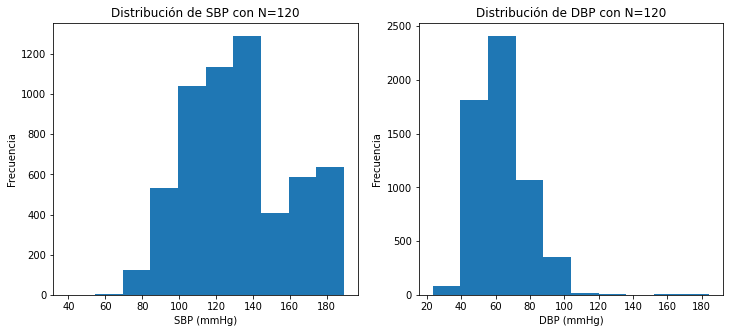

In [ ]:
import matplotlib.pyplot as plt
y_120[2] = pd.to_numeric(y_120[2], downcast='float')
y_120[3] = pd.to_numeric(y_120[3], downcast='float')
figure, axis = plt.subplots(1, 2, figsize=(12,5))
axis[0].hist(y_120[2].values, bins= 10)
axis[0].set_xlabel('SBP (mmHg)')
axis[0].set_ylabel('Frecuencia')
axis[0].set_title('Distribución de SBP con N=120')
axis[1].hist((y_120[3].values))
axis[1].set_xlabel('DBP (mmHg)')
axis[1].set_ylabel('Frecuencia')
axis[1].set_title('Distribución de DBP con N=120')

In [ ]:
N = 200
y_200 = pd.DataFrame()
for i, data in patients.iterrows():
  icu_stay = data['IcuStay']
  patient_id=data['PatientID']

  
  abp_patient = abp_400.loc[abp_400[1].isin([str(icu_stay)])]
  
  y = abp_patient[0:N]
  print(len(y))
  if (y.shape[0] < N):
    print(y)
    print(patient_id)
    continue
  y_200 = y_200.append(y)
y_200

In [ ]:
y_200.to_csv('/content/drive/My Drive/Proyecto Final/50patients/abp_cnn_200_50patients.csv')

In [ ]:
abp_400.to_csv('/content/drive/My Drive/Proyecto Final/50patients/abp_cnn_400_50patients1.csv')

Text(0.5, 1.0, 'Distribución de DBP con N=400')

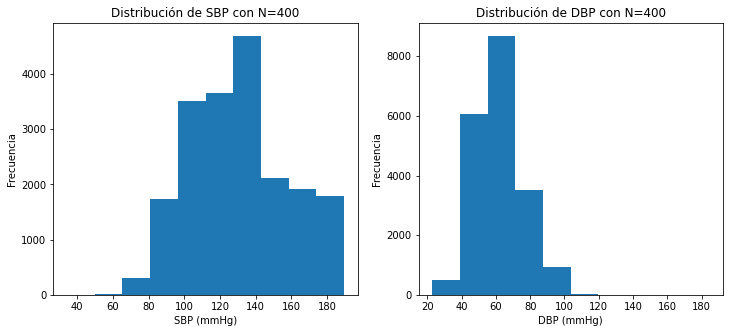

In [ ]:
import matplotlib.pyplot as plt
y_400 = pd.DataFrame()
y_400[2] = pd.to_numeric(abp_400[2], downcast='float')
y_400[3] = pd.to_numeric(abp_400[3], downcast='float')
figure, axis = plt.subplots(1, 2, figsize=(12,5))
axis[0].hist(y_400[2].values, bins= 10)
axis[0].set_xlabel('SBP (mmHg)')
axis[0].set_ylabel('Frecuencia')
axis[0].set_title('Distribución de SBP con N=400')
axis[1].hist((y_400[3].values), bins= 10)
axis[1].set_xlabel('DBP (mmHg)')
axis[1].set_ylabel('Frecuencia')
axis[1].set_title('Distribución de DBP con N=400')

Text(0.5, 1.0, 'Distribución de DBP con N=200')

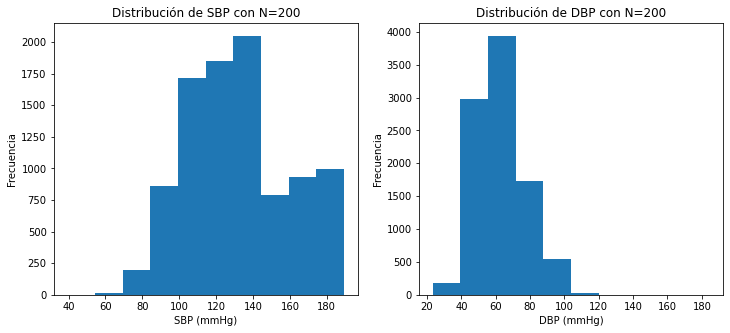

In [ ]:
import matplotlib.pyplot as plt

y_200[2] = pd.to_numeric(y_200[2], downcast='float')
y_200[3] = pd.to_numeric(y_200[3], downcast='float')
figure, axis = plt.subplots(1, 2, figsize=(12,5))
axis[0].hist(y_200[2].values, bins= 10)
axis[0].set_xlabel('SBP (mmHg)')
axis[0].set_ylabel('Frecuencia')
axis[0].set_title('Distribución de SBP con N=200')
axis[1].hist((y_200[3].values), bins= 10)
axis[1].set_xlabel('DBP (mmHg)')
axis[1].set_ylabel('Frecuencia')
axis[1].set_title('Distribución de DBP con N=200')

## Cycle Resultados

Ciclo macro para entrenar modelos (guardamos MAE, loss, desvio en SBP y DBP para cada paciente)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
medias = []
desvios = []
icu_utilizados = []
MAEs, LOSSs = [], []
N = 200

for i, data in patients[35:40].iterrows():
  icu_stay = data['IcuStay']
  patient_id=data['PatientID']
  print(f'Processing ICUStay {icu_stay}...')
  
  ppg_patient = ppg_400.loc[ppg_400['1'].isin([icu_stay])]
  print(f'the shape of ppg_patient is {ppg_patient.shape}')

  x = ppg_patient[0:N]
  x = x.drop(['0','1'], axis=1)
  x = np.transpose(np.transpose(x).head(300))
  x = x.reset_index(drop=True)
  
  
  if (x.shape[0] < N):
    continue

  abp_patient = abp_400.loc[abp_400[1].isin([str(icu_stay)])]
  print(abp_patient)
  print(f'the shape of abp_patient is {abp_patient.shape}')
  
  y = abp_patient[0:N]
  y = y.drop([0,1], axis=1)
  y[2] = pd.to_numeric(y[2], downcast='float')
  y[3] = pd.to_numeric(y[3], downcast='float')
  y = y.reset_index(drop=True)
  y.head()

  #RED

  seed = 7
  np.random.seed(seed)

  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 20, min_lr = 0.0000001, verbose = False)
  stopper = EarlyStopping(monitor = "val_loss", patience = 150, verbose = True, restore_best_weights = True)

  kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
  cvscores = []
  histories = []

  x_norm = (x - x.mean(axis=1)[:,None]) / x.std(axis = 1)[:,None]
  ########
  #verificamos que este bien la normalizacion
  print(f'La media de x_norm es {x_norm.mean(axis = 1)}')
  print(f'El desvío de x_norm es {x_norm.std(axis = 1)}')

  for train, val in kfold.split(x_norm, y):

    x_train = x_norm.iloc[train]
    x_val = x_norm.iloc[val]

    print(f'The shape of x_train is {x_train.shape}')
    print(f'The shape of x_val is {x_val.shape}')

    x_train_resh = np.array(x_train).reshape(-1,300,1)
    x_val_resh = np.array(x_val).reshape(-1,300,1)

    y_train = y.iloc[train]
    y_val = y.iloc[val]
    
    model_v2 = cnn_v2()
    hist = model_v2.fit(x_train_resh, y_train, batch_size=64, epochs=2000, verbose=2,shuffle=True,validation_data=(x_val_resh,y_val),callbacks=[stopper,reduce_lr])
    # evaluate the model
    score = model_v2.evaluate(x_val_resh, y_val)
    print(score)

    histories.append(hist)
    cvscores.append(score)

    val_pred = model_v2.predict(x_val_resh)

    e = np.abs(val_pred - y.iloc[val])
    mean_e = np.mean(e)
    desvio_e = np.std(e)

    print(f'La media del error abs es: {str(mean_e)}')
    print(f'El desvio del error abs es: {str(desvio_e)}')

    icu_utilizados.append(icu_stay)
    medias.append(mean_e)
    desvios.append(desvio_e)

    # scores.append(cvscores)  
    
  for i in cvscores:
      MAEs.append(i[0])
      LOSSs.append(i[1])

media_s, media_d = [], []
for i in medias:
    media_s.append(i[2])
    media_d.append(i[3])

desvio_s, desvio_d = [], []
for i in desvios:
    desvio_s.append(i[2])
    desvio_d.append(i[3])

d = {'ICU': icu_utilizados, 'media_s': media_s, 'desvio_s': desvio_s, 'media_d': media_d, 'desvio_d': desvio_d, 'loss': LOSSs, 'MAE': MAEs}
df = pd.DataFrame(data=d)


df.to_csv('/content/drive/My Drive/Proyecto Final/Resultados_50_cnn_v2_200_parte7.csv')

##ANALISIS LOSS

In [ ]:
ugly = patients.loc[patients['IcuStay']==242986]
ugly

In [ ]:
type(ugly)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
medias = []
desvios = []
icu_utilizados = []
MAEs, LOSSs = [], []
N = 200

for i, data in patients.loc[patients['IcuStay']==273861].iterrows():
  icu_stay = data['IcuStay']
  patient_id=data['PatientID']
  print(f'Processing ICUStay {icu_stay}...')
  
  ppg_patient = ppg_400.loc[ppg_400['1'].isin([icu_stay])]
  print(f'the shape of ppg_patient is {ppg_patient.shape}')

  x = ppg_patient[0:N]
  x = x.drop(['0','1'], axis=1)
  x = np.transpose(np.transpose(x).head(300))
  x = x.reset_index(drop=True)
  
  
  if (x.shape[0] < N):
    continue

  abp_patient = abp_400.loc[abp_400[1].isin([str(icu_stay)])]
  print(abp_patient)
  print(f'the shape of abp_patient is {abp_patient.shape}')
  
  y = abp_patient[0:N]
  y = y.drop([0,1], axis=1)
  y[2] = pd.to_numeric(y[2], downcast='float')
  y[3] = pd.to_numeric(y[3], downcast='float')
  y = y.reset_index(drop=True)
  y.head()

  #RED

  seed = 7
  np.random.seed(seed)

  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 20, min_lr = 0.0000001, verbose = False)
  stopper = EarlyStopping(monitor = "val_loss", patience = 150, verbose = True, restore_best_weights = True)

  x_norm = (x - x.mean(axis=1)[:,None]) / x.std(axis = 1)[:,None]
  print(f'La media de x_norm es {x_norm.mean(axis = 1)}')
  print(f'El desvío de x_norm es {x_norm.std(axis = 1)}')
  import sklearn
  x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_norm, y, test_size=0.1, train_size=0.90, random_state=42, shuffle=True)
  cvscores = []
  histories = []

  print(f'The shape of x_train is {x_train.shape}')
  print(f'The shape of x_val is {x_val.shape}')

  x_train_resh = np.array(x_train).reshape(-1,300,1)
  x_val_resh = np.array(x_val).reshape(-1,300,1)
  
  model_v2 = cnn_v2()
  hist = model_v2.fit(x_train_resh, y_train, batch_size=64, epochs=2000, verbose=2,shuffle=True,validation_data=(x_val_resh,y_val),callbacks=[stopper,reduce_lr])
  # evaluate the model
  score = model_v2.evaluate(x_val_resh, y_val)
  print(score)

  histories.append(hist)
  cvscores.append(score)

  val_pred = model_v2.predict(x_val_resh)

  e = np.abs(val_pred - y_val)
  mean_e = np.mean(e)
  desvio_e = np.std(e)

  print(f'La media del error abs es: {str(mean_e)}')
  print(f'El desvio del error abs es: {str(desvio_e)}')

  icu_utilizados.append(icu_stay)
  medias.append(mean_e)
  desvios.append(desvio_e)

  # scores.append(cvscores)  
  
for i in cvscores:
    MAEs.append(i[0])
    LOSSs.append(i[1])

media_s, media_d = [], []
for i in medias:
    media_s.append(i[2])
    media_d.append(i[3])

desvio_s, desvio_d = [], []
for i in desvios:
    desvio_s.append(i[2])
    desvio_d.append(i[3])

d = {'ICU': icu_utilizados, 'media_s': media_s, 'desvio_s': desvio_s, 'media_d': media_d, 'desvio_d': desvio_d, 'loss': LOSSs, 'MAE': MAEs}
df = pd.DataFrame(data=d)

import matplotlib.pyplot as plt
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = hist.epoch
plt.figure(figsize=[10,10])
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

#df.to_csv('/content/drive/My Drive/Proyecto Final/Resultados_50_cnn_v2_200_parte7.csv')

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
medias = []
desvios = []
icu_utilizados = []
MAEs, LOSSs = [], []
N = 200

for i, data in ugly.iterrows():
  icu_stay = data['IcuStay']
  patient_id=data['PatientID']
  print(f'Processing ICUStay {icu_stay}...')
  
  ppg_patient = ppg_400.loc[ppg_400['1'].isin([icu_stay])]
  print(f'the shape of ppg_patient is {ppg_patient.shape}')

  x = ppg_patient[0:N]
  x = x.drop(['0','1'], axis=1)
  x = np.transpose(np.transpose(x).head(300))
  x = x.reset_index(drop=True)
  
  
  if (x.shape[0] < N):
    continue

  abp_patient = abp_400.loc[abp_400[1].isin([str(icu_stay)])]
  print(abp_patient)
  print(f'the shape of abp_patient is {abp_patient.shape}')
  
  y = abp_patient[0:N]
  y = y.drop([0,1], axis=1)
  y[2] = pd.to_numeric(y[2], downcast='float')
  y[3] = pd.to_numeric(y[3], downcast='float')
  y = y.reset_index(drop=True)
  y.head()

  #RED

  seed = 7
  np.random.seed(seed)

  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 20, min_lr = 0.0000001, verbose = False)
  stopper = EarlyStopping(monitor = "val_loss", patience = 150, verbose = True, restore_best_weights = True)

  x_norm = (x - x.mean(axis=1)[:,None]) / x.std(axis = 1)[:,None]
  import sklearn
  x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_norm, y, test_size=0.15, train_size=0.80, random_state=42, shuffle=True)
  cvscores = []
  histories = []
  
  ########
  #verificamos que este bien la normalizacion
  print(f'La media de x_norm es {x_norm.mean(axis = 1)}')
  print(f'El desvío de x_norm es {x_norm.std(axis = 1)}')

  x_train = x_norm.iloc[train]
  x_val = x_norm.iloc[val]

  print(f'The shape of x_train is {x_train.shape}')
  print(f'The shape of x_val is {x_val.shape}')

  x_train_resh = np.array(x_train).reshape(-1,300,1)
  x_val_resh = np.array(x_val).reshape(-1,300,1)

  y_train = y.iloc[train]
  y_val = y.iloc[val]
  
  model_v2 = cnn_v2()
  hist = model_v2.fit(x_train_resh, y_train, batch_size=64, epochs=2000, verbose=2,shuffle=True,validation_data=(x_val_resh,y_val),callbacks=[stopper,reduce_lr])
  # evaluate the model
  score = model_v2.evaluate(x_val_resh, y_val)
  print(score)

  histories.append(hist)
  cvscores.append(score)

  val_pred = model_v2.predict(x_val_resh)

  e = np.abs(val_pred - y.iloc[val])
  mean_e = np.mean(e)
  desvio_e = np.std(e)

  print(f'La media del error abs es: {str(mean_e)}')
  print(f'El desvio del error abs es: {str(desvio_e)}')

  icu_utilizados.append(icu_stay)
  medias.append(mean_e)
  desvios.append(desvio_e)

  # scores.append(cvscores)  
  
for i in cvscores:
    MAEs.append(i[0])
    LOSSs.append(i[1])

media_s, media_d = [], []
for i in medias:
    media_s.append(i[2])
    media_d.append(i[3])

desvio_s, desvio_d = [], []
for i in desvios:
    desvio_s.append(i[2])
    desvio_d.append(i[3])

d = {'ICU': icu_utilizados, 'media_s': media_s, 'desvio_s': desvio_s, 'media_d': media_d, 'desvio_d': desvio_d, 'loss': LOSSs, 'MAE': MAEs}
df = pd.DataFrame(data=d)

import matplotlib.pyplot as plt
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = hist.epoch
plt.figure(figsize=[10,10])
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 150 patients

In [ ]:
import pandas as pd
patients_list = pd.read_csv('/content/drive/My Drive/Proyecto Final/Lista_150_CAPITULO1.csv')
patients_list = patients_list[['IcuStay','PatientID']]
patients_list

,IcuStay,PatientID
0,200050,p078716
1,200330,p088202
2,200477,p094117
3,200732,p029961
4,200773,p044788
...,...,...
146,286167,p056307
147,282098,p054987
148,204344,p063992
149,210039,p084749


In [ ]:
import pandas as pd
ppg_150 = pd.read_csv('/content/drive/My Drive/Proyecto Final/150patients/ppg_cnn_600_150patients', index_col=0 )
ppg_150.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376
0,p078716,200050,1.242424,1.384164,1.541544,1.740958,1.957967,2.174976,2.376344,2.551320,2.695015,2.804497,2.881720,2.929619,2.951124,2.954057,2.941349,2.916911,2.887586,2.855327,2.818182,2.778104,2.737048,2.695015,2.653959,2.610948,2.566960,2.522972,2.481916,2.442815,2.401760,2.359726,2.315738,2.269795,2.219941,2.165200,2.107527,2.047898,1.985337,1.919844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,p078716,200050,1.366569,1.524927,1.706745,1.901271,2.070381,2.217986,2.366569,2.499511,2.607038,2.685239,2.736070,2.766373,2.777126,2.771261,2.754643,2.731183,2.702835,2.671554,2.637341,2.603128,2.566960,2.530792,2.496579,2.462366,2.429130,2.396872,2.364614,2.330401,2.295210,2.261975,2.227761,2.187683,2.141740,2.089932,2.032258,1.971652,1.908113,1.845552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,p078716,200050,1.264907,1.403715,1.575758,1.772239,1.979472,2.181818,2.367546,2.526882,2.640274,2.719453,2.782991,2.824047,2.843597,2.845552,2.834800,2.812317,2.782014,2.746823,2.706745,2.662757,2.619746,2.585533,2.556207,2.521017,2.482893,2.444770,2.405670,2.363636,2.321603,2.278592,2.234604,2.186706,2.135875,2.086999,2.038123,1.981427,1.921799,1.862170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,p078716,200050,1.207234,1.367546,1.559140,1.771261,1.988270,2.196481,2.383187,2.538612,2.647116,2.717498,2.769306,2.798631,2.804497,2.793744,2.768328,2.733138,2.691105,2.644184,2.593353,2.540567,2.490714,2.444770,2.399804,2.353861,2.306940,2.260020,2.212121,2.161290,2.107527,2.049853,1.990225,1.928641,1.865103,1.809384,1.759531,1.708700,1.659824,1.614858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,p078716,200050,1.172043,1.309873,1.482893,1.654936,1.827957,2.027370,2.228739,2.416422,2.575758,2.701857,2.794721,2.853372,2.881720,2.884653,2.867058,2.835777,2.794721,2.743891,2.686217,2.623656,2.559140,2.496579,2.437928,2.382209,2.326491,2.269795,2.214076,2.159335,2.108504,2.057674,2.000000,1.937439,1.873900,1.812317,1.754643,1.700880,1.653959,1.613881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
abp_150 = pd.read_csv('/content/drive/My Drive/Proyecto Final/150patients/abp_cnn_600_150patients', index_col=0 )
abp_150.head()

,Sistolica,Diastolica,PatientID,IcuStay
0,100.667699,40.394074,p078716,200050
1,113.782341,36.633078,p078716,200050
2,125.016485,36.852877,p078716,200050
3,100.301368,59.003678,p078716,200050
4,110.851695,59.785184,p078716,200050


In [ ]:
import numpy as np
patients = np.unique(ppg_150['1'].values)

In [ ]:
len(patients)

150

In [ ]:
patient_id = patients_list['PatientID'].loc[patients_list['IcuStay']==patients[0]][0]

## Cycle Predicciones

Se guardan los valores de las predicciones para cada entrada.

In [ ]:
N_pulsos = 400
patients_pred = pd.DataFrame()
i=0
for icu_stay in patients:

  patient_id  = patients_list['PatientID'].loc[patients_list['IcuStay']==icu_stay].values[0]
  print(f'Processing Patient {patient_id} with ICUStay {icu_stay}... Patient {i} of {len(patients)}')
  i+=1

  ppg_patient = ppg_150.loc[ppg_150['1'].isin([icu_stay])]
  print(f'The shape of ppg_patient is {ppg_patient.shape}')
  ppg_patient = ppg_patient.drop(['0','1'], axis=1)

  x = ppg_patient[:N_pulsos]
  x = np.transpose(np.transpose(x).head(300))
  x = x.reset_index(drop=True)
  print(f'The shape of patients data of interest, x, is {x.shape}')
  x_norm = normalize(x)
  #print(f'La media de x_norm es {x_norm.mean(axis = 1)} y el desvío {x_norm.std(axis = 1)}')


  abp_patient = abp_150.loc[abp_150['IcuStay'].isin([str(icu_stay)])]
  print(f'The shape of abp_patient is {abp_patient.shape}')
  y = abp_patient[0:N_pulsos]
  y = y.drop(['IcuStay','PatientID'], axis=1)

  y['Sistolica'] = pd.to_numeric(y['Sistolica'], downcast='float')
  y['Diastolica'] = pd.to_numeric(y['Diastolica'], downcast='float')
  y = y.reset_index(drop=True)
  print(f'the shape of y is {y.shape}')
  
  x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_norm, y, test_size=0.1, random_state=42)

  x_train_resh = np.array(x_train).reshape(-1,300,1)
  x_val_resh = np.array(x_val).reshape(-1,300,1)

  model_v2 = cnn_v2()
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 20, min_lr = 0.0000001, verbose = False)
  stopper = EarlyStopping(monitor = "val_loss", patience = 150, verbose = True, restore_best_weights = True)
  hist = model_v2.fit(x_train_resh, y_train, batch_size=64, epochs=2000, verbose=2,shuffle=True,validation_data=(x_val_resh,y_val),callbacks=[stopper,reduce_lr])
  
  df = pd.DataFrame(model_v2.predict(x_val_resh))
  df= df.rename(columns={0:'Sistolica_pred', 1:'Diastolica_pred'})
  df['PatientID'], df['IcuStay'] = patient_id, icu_stay
  y_val = y_val.reset_index()
  df['Sistolica'], df['Diastolica'] = y_val['Sistolica'], y_val['Diastolica']
  df['Error_Sistolica'], df['Error_Diastolica'] = df['Sistolica_pred']-df['Sistolica'], df['Diastolica_pred']-df['Diastolica']
  
  patients_pred = pd.concat([patients_pred, df], axis=0)

patients_pred.to_csv('/content/drive/My Drive/Proyecto Final/150patients/data_pred_150patients_400.csv')

In [ ]:
patients_pred.to_csv('/content/drive/My Drive/Proyecto Final/150patients/data_pred_150patients_400.csv')

## Error

In [ ]:
patients_pred

,Sistolica_pred,Diastolica_pred,PatientID,IcuStay,Sistolica,Diastolica,Error_Sistolica,Error_Diastolica
0,145.971222,74.004509,p078716,200050,149.267578,74.462837,-3.296356,-0.458328
1,142.664825,70.470985,p078716,200050,155.519623,76.660820,-12.854797,-6.189835
2,139.852188,71.000694,p078716,200050,142.356140,66.818733,-2.503952,4.181961
3,147.878036,80.555557,p078716,200050,149.462952,74.438416,-1.584915,6.117142
4,146.830032,73.209282,p078716,200050,149.121048,68.845764,-2.291016,4.363518
...,...,...,...,...,...,...,...,...
35,105.908813,68.283302,p010152,299634,101.499413,64.928337,4.409401,3.354965
36,104.974861,67.991844,p010152,299634,107.855354,69.719734,-2.880493,-1.727890
37,106.322662,68.484955,p010152,299634,107.953133,69.426384,-1.630470,-0.941429
38,102.384651,65.753288,p010152,299634,99.641525,63.754932,2.743126,1.998356


In [ ]:
abs(patients_pred['Error_Sistolica']).mean()

5.219087600708008

In [ ]:
df = pd.DataFrame(model_v2.predict(x_val_resh))
df= df.rename(columns={0:'Sistolica_pred', 1:'Diastolica_pred'})
df['PatientID'], df['IcuStay'] = patient_id, icu_stay
#y_val = y_val.reset_index()
df['Sistolica'], df['Diastolica'] = y_val['Sistolica'], y_val['Diastolica']
df['Error_Sistolica'], df['Error_Diastolica'] = df['Sistolica_pred']-df['Sistolica'], df['Diastolica_pred'] - df['Diastolica']
df

,Sistolica_pred,Diastolica_pred,PatientID,IcuStay,Sistolica,Diastolica,Error_Sistolica,Error_Diastolica
0,147.052902,74.584045,p078716,200050,149.267578,74.462837,-2.214676,0.121208
1,143.759109,69.160118,p078716,200050,155.519623,76.660820,-11.760513,-7.500702
2,140.293274,70.998993,p078716,200050,142.356140,66.818733,-2.062866,4.180260
3,142.397278,79.500763,p078716,200050,149.462952,74.438416,-7.065674,5.062347
4,147.960983,73.199478,p078716,200050,149.121048,68.845764,-1.160065,4.353714
5,152.461868,65.825035,p078716,200050,143.968002,70.921638,8.493866,-5.096603
6,141.203751,67.058731,p078716,200050,158.059525,82.790756,-16.855774,-15.732025
7,147.379242,72.695671,p078716,200050,147.680145,73.192894,-0.300903,-0.497223
8,149.032578,72.958191,p078716,200050,153.419327,78.980919,-4.386749,-6.022728
9,148.487930,75.664566,p078716,200050,150.097931,74.120926,-1.610001,1.543640


In [ ]:
abs(df['Error_Diastolica']).mean()

7.161696434020996

In [ ]:
model_v2.predict(x_val_resh)

array([[147.0529  ,  74.584045],
       [143.75911 ,  69.16012 ],
       [140.29327 ,  70.99899 ],
       [142.39728 ,  79.50076 ],
       [147.96098 ,  73.19948 ],
       [152.46187 ,  65.825035],
       [141.20375 ,  67.05873 ],
       [147.37924 ,  72.69567 ],
       [149.03258 ,  72.95819 ],
       [148.48793 ,  75.664566],
       [137.9546  ,  65.92007 ],
       [147.8132  ,  72.51195 ],
       [154.8996  ,  79.39    ],
       [146.48793 ,  73.095924],
       [138.8665  ,  68.27036 ],
       [142.43034 ,  78.19037 ],
       [153.43118 ,  66.53734 ],
       [149.72069 ,  71.84034 ],
       [144.41469 ,  65.82965 ],
       [150.60237 ,  75.83093 ],
       [150.50104 ,  74.24611 ],
       [134.81276 ,  67.084274],
       [147.63951 ,  68.41275 ],
       [135.51942 ,  64.40456 ],
       [128.84326 ,  58.21033 ],
       [155.39641 ,  79.07306 ],
       [149.64275 ,  73.83877 ],
       [144.36855 ,  73.005745],
       [152.05307 ,  76.15966 ],
       [143.36578 ,  73.16734 ],
       [14

## Cycle Resultados

Se guardan medias, desvios, loss y MAE final para cada paciente.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
medias = []
desvios = []
icu_utilizados = []
MAEs, LOSSs = [], []
N = 200

for i, data in patients[35:40].iterrows():
  icu_stay = data['IcuStay']
  patient_id=data['PatientID']
  print(f'Processing ICUStay {icu_stay}...')
  
  ppg_patient = ppg_400.loc[ppg_400['1'].isin([icu_stay])]
  print(f'the shape of ppg_patient is {ppg_patient.shape}')

  x = ppg_patient[0:N]
  x = x.drop(['0','1'], axis=1)
  x = np.transpose(np.transpose(x).head(300))
  x = x.reset_index(drop=True)
  
  
  if (x.shape[0] < N):
    continue

  abp_patient = abp_400.loc[abp_400[1].isin([str(icu_stay)])]
  print(abp_patient)
  print(f'the shape of abp_patient is {abp_patient.shape}')
  
  y = abp_patient[0:N]
  y = y.drop([0,1], axis=1)
  y[2] = pd.to_numeric(y[2], downcast='float')
  y[3] = pd.to_numeric(y[3], downcast='float')
  y = y.reset_index(drop=True)
  y.head()

  #RED

  seed = 7
  np.random.seed(seed)

  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 20, min_lr = 0.0000001, verbose = False)
  stopper = EarlyStopping(monitor = "val_loss", patience = 150, verbose = True, restore_best_weights = True)

  kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
  cvscores = []
  histories = []

  x_norm = (x - x.mean(axis=1)[:,None]) / x.std(axis = 1)[:,None]
  ########
  #verificamos que este bien la normalizacion
  print(f'La media de x_norm es {x_norm.mean(axis = 1)}')
  print(f'El desvío de x_norm es {x_norm.std(axis = 1)}')

  for train, val in kfold.split(x_norm, y):

    x_train = x_norm.iloc[train]
    x_val = x_norm.iloc[val]

    print(f'The shape of x_train is {x_train.shape}')
    print(f'The shape of x_val is {x_val.shape}')

    x_train_resh = np.array(x_train).reshape(-1,300,1)
    x_val_resh = np.array(x_val).reshape(-1,300,1)

    y_train = y.iloc[train]
    y_val = y.iloc[val]
    
    model_v2 = cnn_v2()
    hist = model_v2.fit(x_train_resh, y_train, batch_size=64, epochs=2000, verbose=2,shuffle=True,validation_data=(x_val_resh,y_val),callbacks=[stopper,reduce_lr])
    # evaluate the model
    score = model_v2.evaluate(x_val_resh, y_val)
    print(score)

    histories.append(hist)
    cvscores.append(score)

    val_pred = model_v2.predict(x_val_resh)

    e = np.abs(val_pred - y.iloc[val])
    mean_e = np.mean(e)
    desvio_e = np.std(e)

    print(f'La media del error abs es: {str(mean_e)}')
    print(f'El desvio del error abs es: {str(desvio_e)}')

    icu_utilizados.append(icu_stay)
    medias.append(mean_e)
    desvios.append(desvio_e)

    # scores.append(cvscores)  
    
  for i in cvscores:
      MAEs.append(i[0])
      LOSSs.append(i[1])

media_s, media_d = [], []
for i in medias:
    media_s.append(i[2])
    media_d.append(i[3])

desvio_s, desvio_d = [], []
for i in desvios:
    desvio_s.append(i[2])
    desvio_d.append(i[3])

d = {'ICU': icu_utilizados, 'media_s': media_s, 'desvio_s': desvio_s, 'media_d': media_d, 'desvio_d': desvio_d, 'loss': LOSSs, 'MAE': MAEs}
df = pd.DataFrame(data=d)


df.to_csv('/content/drive/My Drive/Proyecto Final/Resultados_50_cnn_v2_200_parte7.csv')

In [ ]:
patients_list['PatientID'].loc[patients_list['IcuStay']==icu_stay].values[0]

'p010152'

In [ ]:
ppg_400.loc[ppg_400['1'].isin([icu_stay])]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376


## Distribuciones en train

In [ ]:
N_pulsos = 400
y_train_400 = pd.DataFrame()
i=0
for icu_stay in patients:

  patient_id  = patients_list['PatientID'].loc[patients_list['IcuStay']==icu_stay].values[0]
  print(f'Processing Patient {patient_id} with ICUStay {icu_stay}... Patient {i} of {len(patients)}')
  i+=1

  ppg_patient = ppg_150.loc[ppg_150['1'].isin([icu_stay])]
  print(f'The shape of ppg_patient is {ppg_patient.shape}')
  ppg_patient = ppg_patient.drop(['0','1'], axis=1)

  x = ppg_patient[:N_pulsos]
  x = np.transpose(np.transpose(x).head(300))
  x = x.reset_index(drop=True)
  print(f'The shape of patients data of interest, x, is {x.shape}')
  x_norm = normalize(x)
  #print(f'La media de x_norm es {x_norm.mean(axis = 1)} y el desvío {x_norm.std(axis = 1)}')


  abp_patient = abp_150.loc[abp_150['IcuStay'].isin([str(icu_stay)])]
  print(f'The shape of abp_patient is {abp_patient.shape}')
  y = abp_patient[0:N_pulsos]
  y = y.drop(['IcuStay','PatientID'], axis=1)

  y['Sistolica'] = pd.to_numeric(y['Sistolica'], downcast='float')
  y['Diastolica'] = pd.to_numeric(y['Diastolica'], downcast='float')
  y = y.reset_index(drop=True)
  print(f'the shape of y is {y.shape}')
  
  x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_norm, y, test_size=0.1, random_state=42)
  y_train_400 = y_train_400.append(y_train)

In [ ]:
y_train_400

,Sistolica,Diastolica
381,152.955307,79.200714
55,154.347366,75.146652
76,139.962784,67.551399
25,151.123657,74.145348
82,144.700653,71.336815
...,...,...
71,101.108276,68.155197
106,105.997459,66.981789
270,107.073082,67.861847
348,100.912712,68.155197


Text(0.5, 1.0, 'Distribución de DBP en entrenamiento')

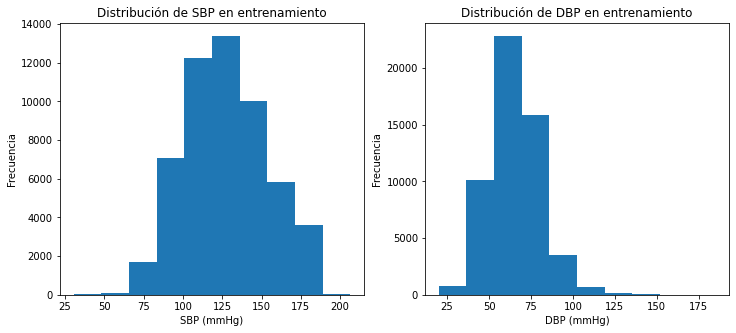

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(12,5))
axis[0].hist((y_train_400.Sistolica))
axis[0].set_xlabel('SBP (mmHg)')
axis[0].set_ylabel('Frecuencia')
axis[0].set_title('Distribución de SBP en entrenamiento')
axis[1].hist((y_train_400.Diastolica))
axis[1].set_xlabel('DBP (mmHg)')
axis[1].set_ylabel('Frecuencia')
axis[1].set_title('Distribución de DBP en entrenamiento')